In [1]:
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np

In [22]:
trn_fmnist = datasets.FashionMNIST("./data", train=True, download=True)
val_fmnist = datasets.FashionMNIST("./data", train=False, download=True)

data_threshold = 10000

trn_data = trn_fmnist.data[:data_threshold]
trn_targets = trn_fmnist.targets[:data_threshold]
val_data = val_fmnist.data[:data_threshold]
val_targets = val_fmnist.targets[:data_threshold]

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [84]:
class FmnistDataset(Dataset):
  def __init__(self, x: torch.Tensor, y: torch.Tensor):
    super().__init__()
    self.x = x.view(x.shape[0], -1).float().to(device) / 255
    self.y = y.to(device)

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

trn_dataset = FmnistDataset(trn_data, trn_targets)
val_dataset = FmnistDataset(val_data, val_targets)
trn_dataloader = DataLoader(trn_dataset, batch_size=256, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=True)

In [85]:
class SimpleNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.25),
        nn.Linear(28*28, 500),
        nn.Dropout(0.25),
        nn.BatchNorm1d(500),
        nn.ReLU(),

        nn.Linear(500, 10),
    )

  def forward(self, x):
    x = x.float().to(device)
    x = self.fc(x)
    return x

In [86]:
def measure_accuracy(_y, y):
  return (_y.argmax(dim=-1) == y).sum().item() / len(y)

In [87]:
model = SimpleNN().to(device)
opt = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer = opt,
    factor = 0.4,
    patience=2,
    threshold=0.003,
    threshold_mode='rel',
)

In [88]:
epochs = 30
trn_losses = []
val_losses = []

trn_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    avg_loss = 0

    for x, y in trn_dataloader:
        model.train()

        _y = model(x)
        loss = criterion(_y, y)

        avg_loss += loss.item()

        opt.zero_grad()
        loss.backward()
        opt.step()

        trn_losses.append(loss.item())
        trn_accuracies.append(measure_accuracy(_y, y))

        # validation dataset
        with torch.no_grad():
            model.eval()
            _y_val = model(val_dataset.x)
            val_loss = criterion(_y_val, val_dataset.y)

            val_losses.append(val_loss.item())
            val_accuracies.append(measure_accuracy(_y_val, val_dataset.y))

    avg_loss /= len(trn_dataloader)
    scheduler.step(avg_loss)
    print(f"Epoch: {epoch}, avg loss: {avg_loss}, val accuracy: {val_accuracies[-1]}, lr: {opt.param_groups[0]['lr']}")

Epoch: 0, avg loss: 0.8358201652765274, val accuracy: 0.7752, lr: 0.001
Epoch: 1, avg loss: 0.5451372489333153, val accuracy: 0.8113, lr: 0.001
Epoch: 2, avg loss: 0.500400184839964, val accuracy: 0.828, lr: 0.001
Epoch: 3, avg loss: 0.46847346276044843, val accuracy: 0.828, lr: 0.001
Epoch: 4, avg loss: 0.46034178510308266, val accuracy: 0.8318, lr: 0.001
Epoch: 5, avg loss: 0.44269339814782144, val accuracy: 0.8352, lr: 0.001
Epoch: 6, avg loss: 0.41667439192533495, val accuracy: 0.844, lr: 0.001
Epoch: 7, avg loss: 0.40472977608442307, val accuracy: 0.8458, lr: 0.001
Epoch: 8, avg loss: 0.3954118132591248, val accuracy: 0.8464, lr: 0.001
Epoch: 9, avg loss: 0.3860042244195938, val accuracy: 0.8474, lr: 0.001
Epoch: 10, avg loss: 0.3824973709881306, val accuracy: 0.8442, lr: 0.001
Epoch: 11, avg loss: 0.37919342815876006, val accuracy: 0.8429, lr: 0.001
Epoch: 12, avg loss: 0.3666666992008686, val accuracy: 0.8478, lr: 0.001
Epoch: 13, avg loss: 0.3648577108979225, val accuracy: 0.84

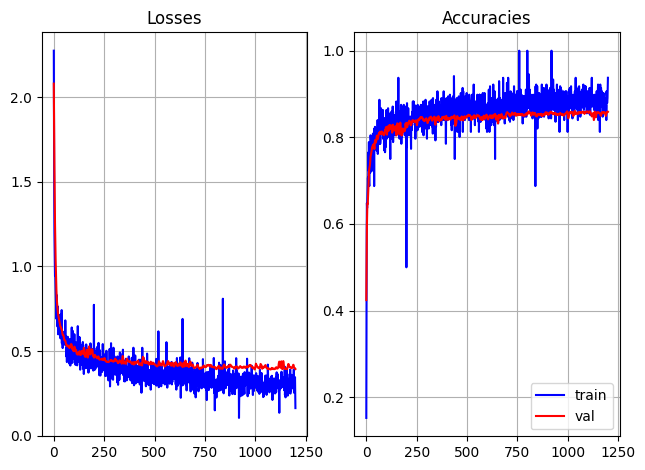

In [90]:
plt.subplot(121)
plt.title("Losses")
plt.plot(trn_losses, label="train", color='blue')
plt.plot(val_losses, label="val", color='red')
plt.grid()

plt.subplot(122)
plt.title("Accuracies")
plt.plot(trn_accuracies, label='train', color='blue')
plt.plot(val_accuracies, label='val', color='red')

plt.legend()
plt.tight_layout()
plt.grid()

Text(0.5, 1.0, 'h1->_y weights')

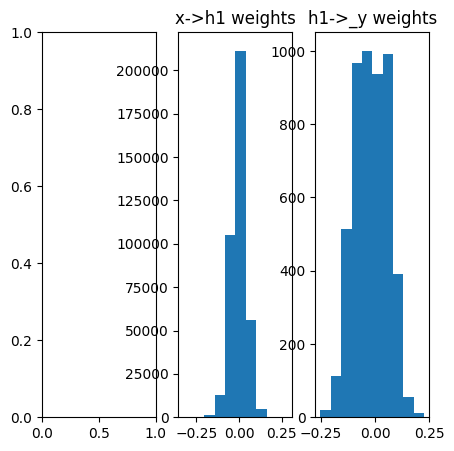

In [91]:
fig, axs = plt.subplots(1, 3, figsize=(5,5))

# axs[0].hist(model.fc[2](model.fc[2](val_dataset.x)).detach().float().flatten().numpy())
# axs[0].set_title("Values distribution first hidden layer")

axs[1].hist(model.fc[2].weight.detach().float().flatten().numpy())
axs[1].set_title("x->h1 weights")

axs[2].hist(model.fc[-1].weight.detach().float().flatten().numpy())
axs[2].set_title("h1->_y weights")

In [103]:
torch.save(model.to(torch.device('cpu')).state_dict(), 'C:/Users/zeyad/Desktop/Workspace/Code/Sandbox/ComputerVisionWithDeepLearning/Section2-ObjectClassificationAndDetection/Ch4-ConvolutionNeuralNetwork/mymodel.pt')

(tensor([8]), tensor(8))

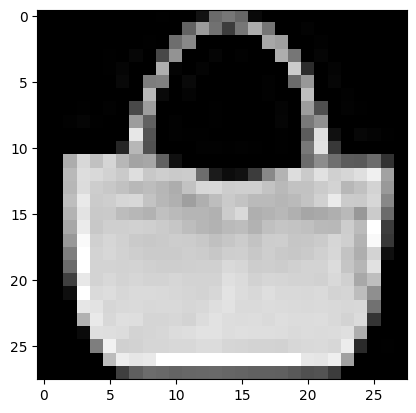

In [102]:
model.eval()

ix = 100

plt.imshow(trn_data[ix], cmap='gray')
model((trn_data[ix])[None]).argmax(dim=-1), trn_targets[ix]
